# Regression on RBS sequences - Escherichia coli

This notebook shows the regression of RBS sequences.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - Label
    - One-hot embedding
    - K-mer 
    - PMW (to be added)
    - Unsupervised (to be added)
- Kernels
    - Spectrum
    - Mixed Spectrum
    - Weighted Degree
    - Weighted Degree with Shifting
- Evaluate
    - R2 score
    - Plot

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading the Dataset

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [4]:
df = df.drop_duplicates(subset =['B', 'C'])

new_df = df[['B', 'C']].dropna()
# mean normalization 
# new_df['normalized_F'] = (new_df['F'] - new_df['F'].mean())/new_df['F'].std()
# min-max normalization
new_df['normalized_C'] = (new_df['C'] - new_df['C'].min())/(new_df['C'].max() - new_df['C'].min())
data = np.asarray(new_df[['B', 'normalized_C']])
data.shape

(113, 2)

## Regression

- Kernel Ridge Regression
- Gaussian Process Regression


In [5]:
cross_val_flag = False
kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]

### Kernel Ridge Regression 

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.17498357503519216
Test RMSE:  0.23697550581728308


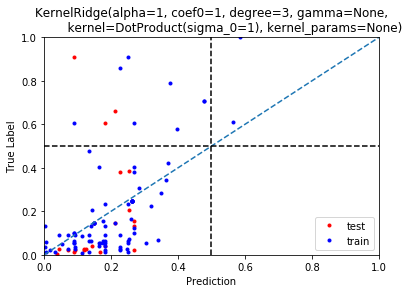

In [6]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag)

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.20372091113816757
Test RMSE:  0.25335940037303006


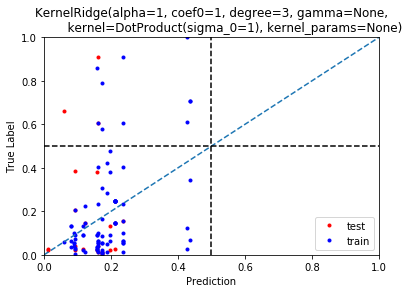

In [7]:
# kmer embedding with DotProduct kernel (l = 3)

reg = Regression(KernelRidge(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag)

In [ ]:
# Show string kernel performance (l = 3)
# label embedding 

for kernel in kernels:
    reg = Regression(KernelRidge(kernel = kernel), data, embedding_method='label')
    reg.train()
    reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)
    print()

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7fa1bb0d0378>,
            kernel_params=None)
Train RMSE:  0.16853178909474487
Test RMSE:  0.2716912829593022

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7fa1bb0d0400>,
            kernel_params=None)
Train RMSE:  0.17186650092145733
Test RMSE:  0.26580441606885435

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7fa1bb0d0488>,
            kernel_params=None)
Train RMSE:  0.15982761197484005
Test RMSE:  0.22877782480605377



### Gaussian Process Regression

In [ ]:
# # baseline: onehot embedding with DotProduct Kernel 
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'onehot')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)

In [ ]:
# kmer embedding (l = 3)
reg = Regression(GaussianProcessRegressor(kernel = DotProduct()), data, 'kmer')
reg.train()
reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)

In [ ]:
# Show string kernel performance (l = 3)
# label embedding 

for kernel in kernels:
    reg = Regression(GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel)), data,\
                 embedding_method='label')
    reg.train()
    reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = False)
    print()